In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns

from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull

import itertools

from utils import *

plt.style.use('seaborn-darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

np.random.seed(260647775)

In [2]:
def condition(coord):
    x, y = coord
    
    return (x-25)**2 + (y-25)**2 < 225 # radius 15

grid      = [[(x, y) for y in range(50)] for x in range(50)]
grayscale = [[2 if condition(tup) else 0.5 for tup in row] for row in grid]

In [3]:
noise = np.random.normal(0, 0.7, size=(50, 50))

In [4]:
noisy_image = grayscale - noise
#np.putmask(noisy_image, noisy_image < 0, 0)
#np.putmask(noisy_image, noisy_image > 1, 1)

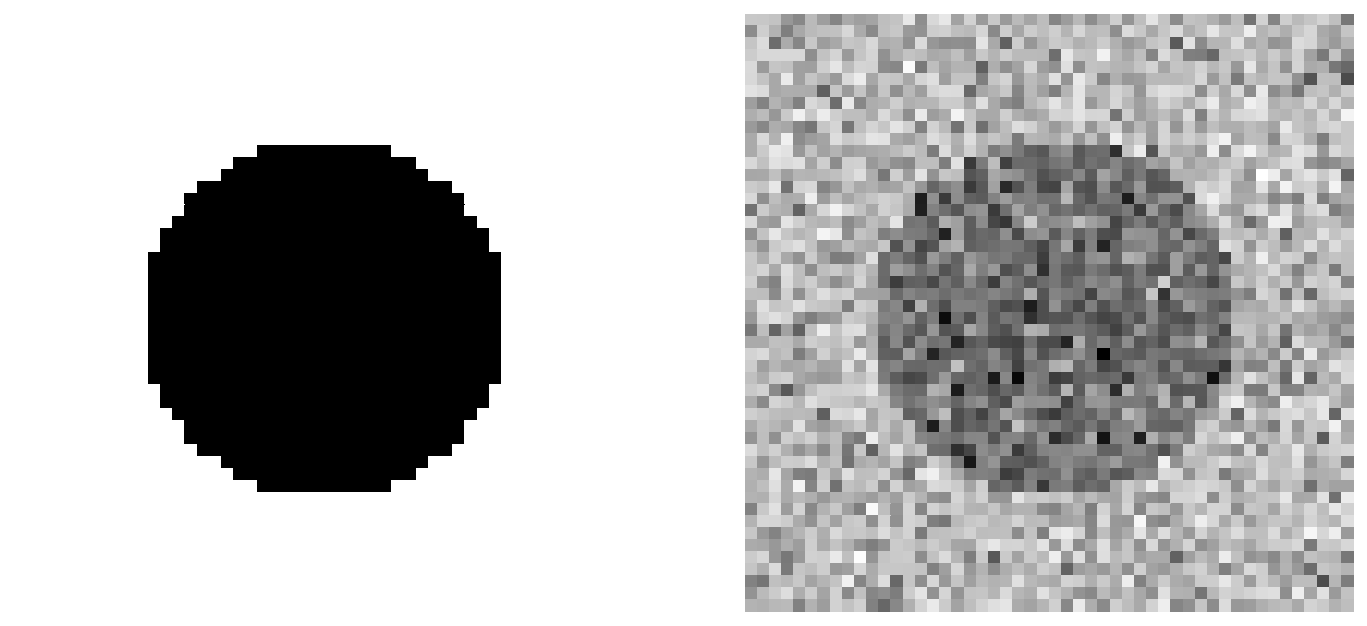

In [5]:
fig, axes = plt.subplots(figsize=(12, 5.5), nrows=1, ncols=2)
axes[0]   = sns.heatmap(grayscale,
                        cmap='Greys',
                        cbar=False,
                        xticklabels='',
                        yticklabels='',
                        ax=axes[0])
plt.axis('off')
axes[1] = sns.heatmap(noisy_image,
                      cmap='Greys',
                      cbar=False,
                      xticklabels='',
                      yticklabels='',
                      ax=axes[1])

#### Initialization of random points

In [6]:
num_points = 30
points = random_tessellation_points(num_points)

In [7]:
vor = Voronoi(points)
regions, vertices = voronoi_finite_polygons_2d(vor)
updated_vertices = {i: restricted_vertices(vertices[regions[i]], points[i]) for i in range(len(points))}

<Figure size 720x504 with 0 Axes>

In [8]:
# manually add corners somewhere
# order no longer matters
for corner in [(0, 0), (0, 50), (50, 0), (50, 50)]:
    
    region_where_corner_belongs = np.argmin([l2_norm(p, corner) for p in points])
    temp_vertices = updated_vertices[region_where_corner_belongs].copy()
    
    updated_vertices[region_where_corner_belongs] = np.array(list(temp_vertices) + [corner] )

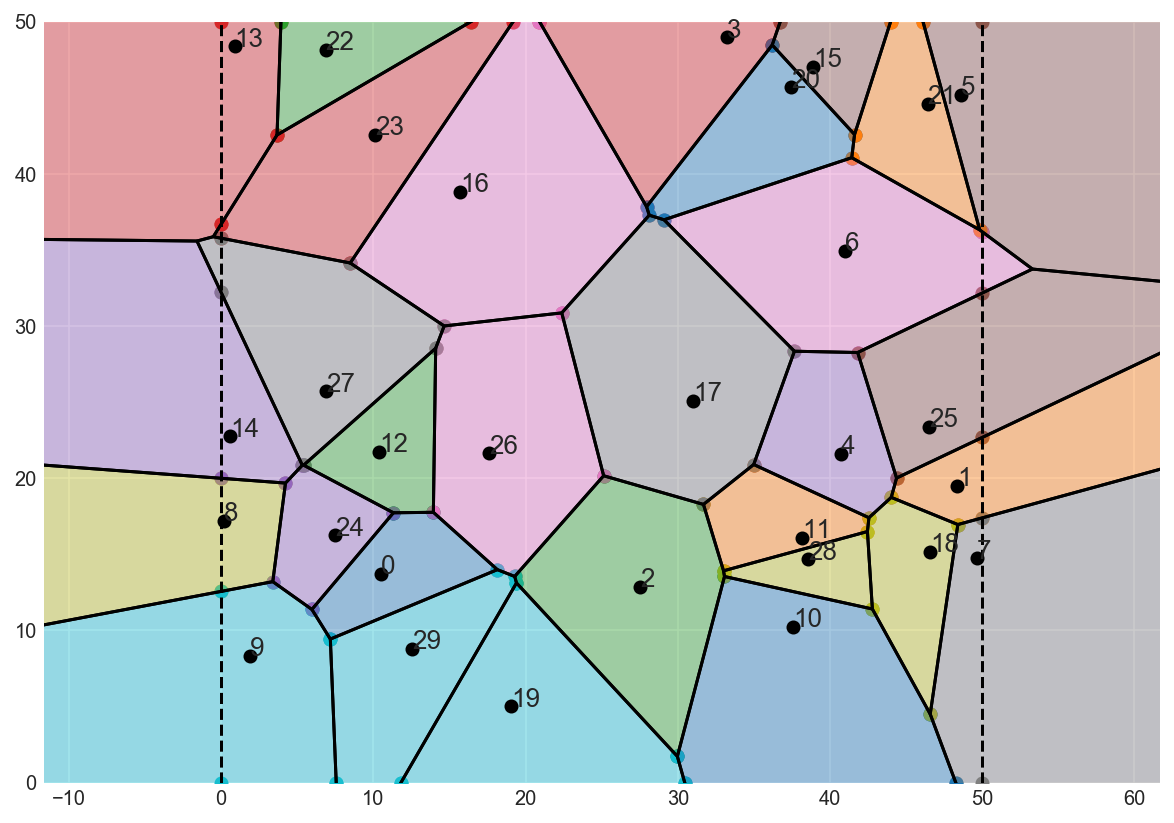

In [9]:
plot(points)

for i, region in enumerate(regions):
    try:
        a, b = zip(*updated_vertices[i])
        plt.scatter(a, b)
    except Exception as e:
        pass

In [10]:
total_area = 0
for i in range(num_points):
    print('{}th region: {} vertices\t area = {}'.format(i, len(updated_vertices[i]), PolyArea(updated_vertices[i])))
    total_area += PolyArea(updated_vertices[i])
print('Total area: ', np.around(total_area, 3))

0th region: 5 vertices	 area = 50.14919664914544
1th region: 5 vertices	 area = 21.262188135397082
2th region: 7 vertices	 area = 142.96946838046574
3th region: 4 vertices	 area = 99.75316337057484
4th region: 6 vertices	 area = 66.88250873647121
5th region: 4 vertices	 area = 27.729222997842953
6th region: 7 vertices	 area = 167.78679251617905
7th region: 5 vertices	 area = 43.13857529355744
8th region: 4 vertices	 area = 26.43924332789979
9th region: 6 vertices	 area = 89.72344916028128
10th region: 6 vertices	 area = 178.41139688648434
11th region: 5 vertices	 area = 42.99467641564206
12th region: 4 vertices	 area = 50.36629828117134
13th region: 4 vertices	 area = 39.08998493982867
14th region: 4 vertices	 area = 35.21984502674073
15th region: 4 vertices	 area = 32.62694725562051
16th region: 7 vertices	 area = 223.5620285211039
17th region: 7 vertices	 area = 184.90357581340004
18th region: 6 vertices	 area = 52.026970675274924
19th region: 4 vertices	 area = 128.6187403954844
20t

#### Constants


In [11]:
lam = 15 # lambda
alpha = 1 # alpha
beta  = 1 # beta
sigma = 0.7

coordinates = np.array([[(i + 0.5, j + 0.5) for i in range(50)] for j in range(50)])
coordinates = coordinates.reshape(-1, 2)

#### Sampler

In [12]:
class UpdatedVoronoi:
    def __init__(self, _points):
        self.points = _points
        self.vor = Voronoi(_points)
        self.regions, self.vertices = voronoi_finite_polygons_2d(self.vor)
        

        self.areas = np.array([PolyArea(self.updated_vertices[i]) for i in range(len(_points))]) # hashable
        self.x_heights = [] # indices
        
        for (u, v) in coordinates:
            self.x_heights.append(np.argmin(cdist(_points, [[u, v]]).reshape(-1,)))
    
    @property
    def updated_vertices(self):
        new_vertices = {i: restricted_vertices(self.vertices[self.regions[i]], _points[i]) for i in range(len(_points))}

        for corner in [(0, 0), (0, 50), (50, 0), (50, 50)]:

            region_where_corner_belongs = np.argmin([l2_norm(p, corner) for p in _points])
            temp_vertices = self.new_vertices[region_where_corner_belongs].copy()

            self.new_vertices[region_where_corner_belongs] = np.array(list(temp_vertices) + [corner])

In [13]:
NUM_ITER = 200
k = 15
points = random_tessellation_points(k)
heights = truncated_poisson(lam=lam, size=k)


old_Voronoi = UpdatedVoronoi(points)

NameError: name '_points' is not defined

<Figure size 720x504 with 0 Axes>

In [ ]:
R = 2

if R < 3:
    # birth process
    new_point   = np.random.uniform(low=0, high=50, size=[1, 2])
    temp_points = np.concatenate((points, new_point.reshape(1, 2)))
    
    new_Voronoi = UpdatedVoronoi(temp_points)
    new_Voronoi.areas # new point is last in list

In [ ]:
J = get_neighbors(new_Voronoi.vor.ridge_points, k) # k is last index of new voronoi, J as defined in Green (1995)
diff_areas = (old_Voronoi.areas - new_Voronoi.areas[:-1])

assert all(np.argwhere(diff_areas > 0).reshape(-1).astype(np.int32) == np.sort(J))

S, T = diff_areas[J], new_Voronoi.areas[J] # change in areas, new areas

assert np.abs(sum(S) - new_Voronoi.areas[-1]) < 1e-7 # change in areas same as area of new region

v = inverse_v(np.random.uniform(0, 1))
h_tilde = np.exp(1/sum(S)*(S@np.log(heights[J]))) # no worries about height = 0
h_star  = h_tilde*v
heights = np.array(list(heights) + [h_star])

new_heights  = heights[J]**(1+S/T)*(np.tile(h_star, len(J))**(-S/T))
loglikeratio = log_likelihood_ratio(noisy_image.reshape(-1,), 
                                    heights[new_Voronoi.x_heights], 
                                    heights[old_Voronoi.x_heights])
# check if R < or > than 0
logR = loglikeratio - \
       sum(new_heights - heights[J]) - \
       np.log(poisson_ratio_pdf(k)*h_tilde/f(v)) - \
       np.log(sum((S+T)*new_heights/(T*new_heights)))

In [ ]:
plot(points)

In [ ]:
plot(temp_points)

In [ ]:
3 in old_Voronoi.updated_vertices.keys()

In [ ]:
a = old_Voronoi.updated_vertices[3]
b = old_Voronoi.updated_vertices[12]

In [ ]:
np.intersect1d(a[:, 1], b[:, 1])

In [ ]:
def get_neighbors(updated_vor, i):
    assert i in updated_vor.updated_vertices.keys()
    
    i_vertices = updated_vor.updated_vertices[i]
    neighbors  = []
    
    for j in range(len(updated_vor.points)):
        
        if i == j:
            continue
            
        j_vertices = updated_vor.updated_vertices[j] # temp
        
        x_intersects = np.intersect1d(i_vertices[:, 0], j_vertices[:, 0])
        y_intersects = np.intersect1d(i_vertices[:, 1], j_vertices[:, 1])
        
        same_x_coord = np.array([_i for (_i, x) in enumerate(x_intersects) if x in i_vertices])
        same_y_coord = np.array([_j for (_j, x) in enumerate(x_intersects) if x in j_vertices])
        
        print(same_x_coord, same_y_coord)
        if same_x_coord != []:
            vertices_in_common = np.intersect1d(same_x_coord, same_y_coord)
            
            if len(vertices_in_common) == len(same_x_coord):
                assert len(vertices_in_common) == 2
                neighbors.append(j)
            
    return np.array(neighbors)